# Building the model - manually

While TPOT runs on my other PC, lets see what kind of results we can get by manually constructing a classifier.

In [18]:
import pandas as pd
from tqdm import tqdm_notebook

data_dir = "../data/2018-08-10_AV_Innoplexus/"

train_df = pd.read_csv(data_dir+'train_df_tfidf.csv')

train_df.head()

,patient,cancer,health,inform,research,product,clinic,trial,use,develop,...,skin,throughout,mobil,centr,whether,order,among,topic,graduat,Tag
0,0.127475,0.034668,-0.016241,-0.035748,-0.025646,0.029427,-0.014449,-0.031583,-0.017623,-0.015653,...,0.000810,0.011403,-0.007790,-0.000973,0.003064,-0.010777,-0.008425,-0.005903,0.005978,news
1,0.164749,0.077254,-0.006378,-0.061128,-0.022471,0.036405,-0.021808,-0.061794,-0.016710,-0.029654,...,0.011107,0.007076,0.007515,0.014599,0.007247,-0.021032,0.011381,-0.009899,-0.010999,news
2,0.098529,0.051075,0.007707,-0.033645,-0.001004,0.008717,-0.004370,-0.029041,-0.018962,-0.013693,...,0.030903,0.021203,-0.011202,0.010692,0.005343,0.011659,-0.010961,-0.000336,-0.022726,news
3,0.088048,0.023048,-0.015557,-0.021367,-0.013249,0.020228,-0.002672,-0.017674,-0.010437,-0.003418,...,-0.001816,0.007043,-0.011340,-0.016000,0.007782,-0.010025,0.012487,0.001523,0.006619,news
4,0.110766,0.016241,-0.024661,-0.016092,-0.017855,0.011198,-0.013458,-0.010642,-0.021301,0.002299,...,0.008068,-0.011592,0.022872,0.045125,0.011489,0.019910,-0.012513,-0.001174,-0.001803,news


In [19]:
#Encode tags
tags = train_df['Tag'].unique().tolist()
tags.sort()

tag_dict = {key: value for (key, value) in zip(tags,range(len(tags)))}

train_df['Tag_encoded'] = train_df['Tag'].map(tag_dict)
train_df_encoded = train_df.drop('Tag',axis=1)

# Which model? Why?

So some good classic models for this type of task include all the typical characters; 

NaiveBayes, SVM, Random Forest, Logistic Regression, NeuralNet to name a few. I'll start with those with default settings and see how things go.

Other strategies I might want to employ include;

1. Extraction of further words from the html
2. Over/Undersampling to achieve parity between classes in the training data.
3. Hyperparameter optimization

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

logreg = LogisticRegression(penalty='l2',)
naiveB = GaussianNB()
svc = SVC()
rforest = RandomForestClassifier(n_estimators=20, n_jobs=2)
#From TPOT
etrees = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.7500000000000001, min_samples_leaf=3, min_samples_split=2, n_estimators=100, n_jobs=2)
neural = MLPClassifier()
model_names = ["LogReg","NaiveB","SVC","RForest","ETrees","Neural"]

In [47]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, confusion_matrix

x_cols = [x for x in train_df_encoded.columns if x != "Tag_encoded"]
X_train, X_test, y_train, y_test = train_test_split(train_df_encoded, train_df_encoded['Tag_encoded'], test_size=0.33)

In [48]:
fit_models = []
model_preds = []
cross_val_scores = []
f1_scores = []
conf_matrices = []

for name, model in tqdm_notebook(zip(model_names,[logreg, naiveB, svc, rforest, etrees, neural])):
    print("Working on ",name,"...")
    cross_score = cross_val_score(model, X_train, y_train, cv=5, n_jobs=2)
    model.fit(X_train, y_train)
    fit_models.append(model)
    preds = model.predict(X_test)
    model_preds.append(preds)
    model_f1 = f1_score(y_test, preds, average='micro')
    model_conf = confusion_matrix(y_test, preds)
    print("Done!")
    cross_val_scores.append(cross_score)
    f1_scores.append(model_f1)
    conf_matrices.append(model_conf)

Working on  LogReg ...
Done!
Working on  NaiveB ...
Done!
Working on  SVC ...
Done!
Working on  RForest ...
Done!
Working on  ETrees ...
Done!
Working on  Neural ...
Done!


In [49]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(True)

In [50]:
#Plot cv_scores
cv_scores_data = go.Bar(
    x = model_names,
    y = [x.mean() for x in cross_val_scores],
    name='Cross Validation Score'
)

f1_scores_data = go.Bar(
    x = model_names,
    y = [x.tolist() for x in f1_scores],
    name="F1-micro Score"
)

cv_scores_layout = go.Layout(
    title="Cross Validation & F1-micro Scores"
)

cv_scores_fig = go.Figure(
    data=[cv_scores_data, f1_scores_data],
    layout=cv_scores_layout
)

iplot(cv_scores_fig)

## Lets look at the confusion matrices.

In [74]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, name,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    title= str(name+' Confusion matrix'),
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

LogReg
Normalized confusion matrix


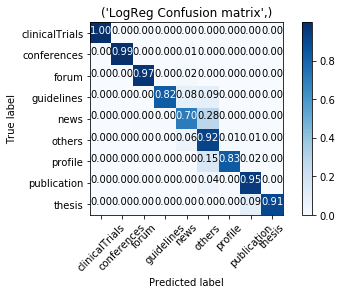

NaiveB
Normalized confusion matrix


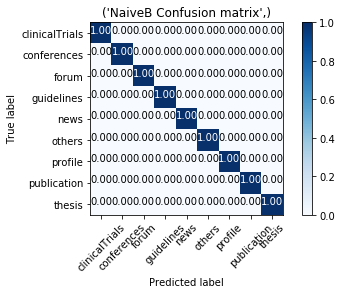

SVC
Normalized confusion matrix


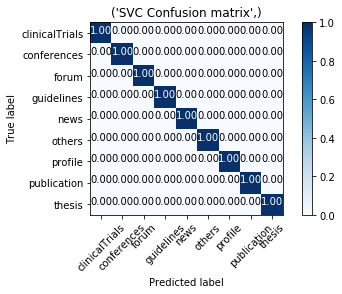

RForest
Normalized confusion matrix


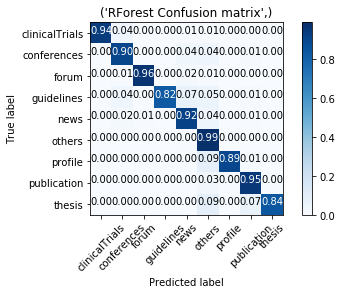

ETrees
Normalized confusion matrix


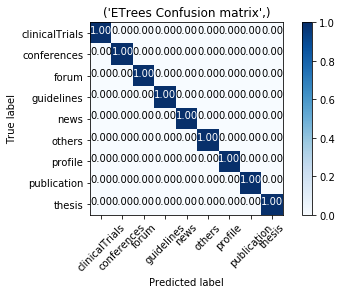

Neural
Normalized confusion matrix


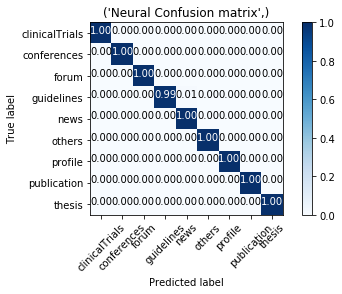

In [75]:
for m_name, conf_matrix in zip(model_names, conf_matrices):
    print(m_name)
    plot_confusion_matrix(conf_matrix, classes=tag_dict.keys(), name=m_name,
                         normalize=True)

Huh, something doesn't seem right - are they really that good? I'm going to go ahead and try to generate a first answer just to get something into the competition.

Because extended trees keeps getting supported by my TPOT instance (that's still running) - I'm going to build my first submission with that model.